In [10]:
%matplotlib inline
import numpy as np
import pathlib
import matplotlib.pyplot as plt

log_path = pathlib.Path('log/kubric_single_car/decompose_v9_good/renders-runtime/00100000/runtime_eval/model_out')
files = list(sorted(log_path.glob('*.npy')))
np.set_printoptions(suppress=True)
ID = 2
OUT = np.load(str(files[ID]), allow_pickle=True).item()
files

[PosixPath('log/kubric_single_car/decompose_v9_good/renders-runtime/00100000/runtime_eval/model_out/rgba_00000.npy'),
 PosixPath('log/kubric_single_car/decompose_v9_good/renders-runtime/00100000/runtime_eval/model_out/rgba_00049.npy'),
 PosixPath('log/kubric_single_car/decompose_v9_good/renders-runtime/00100000/runtime_eval/model_out/rgba_00099.npy'),
 PosixPath('log/kubric_single_car/decompose_v9_good/renders-runtime/00100000/runtime_eval/model_out/rgba_00149.npy'),
 PosixPath('log/kubric_single_car/decompose_v9_good/renders-runtime/00100000/runtime_eval/model_out/rgba_00199.npy')]

In [2]:
OUT.keys()

dict_keys(['acc', 'alpha_both', 'alpha_d', 'alpha_s', 'blendw', 'density_d', 'depth', 'dists', 'extra_rgb_blendw', 'extra_rgb_dynamic', 'extra_rgb_mask', 'extra_rgb_static', 'med_depth', 'med_points', 'rgb', 'rgb_d', 'rgb_s', 'shadow_r', 'sigma_d', 'sigma_s', 'weights_d', 'weights_s'])

<IPython.core.display.Javascript object>


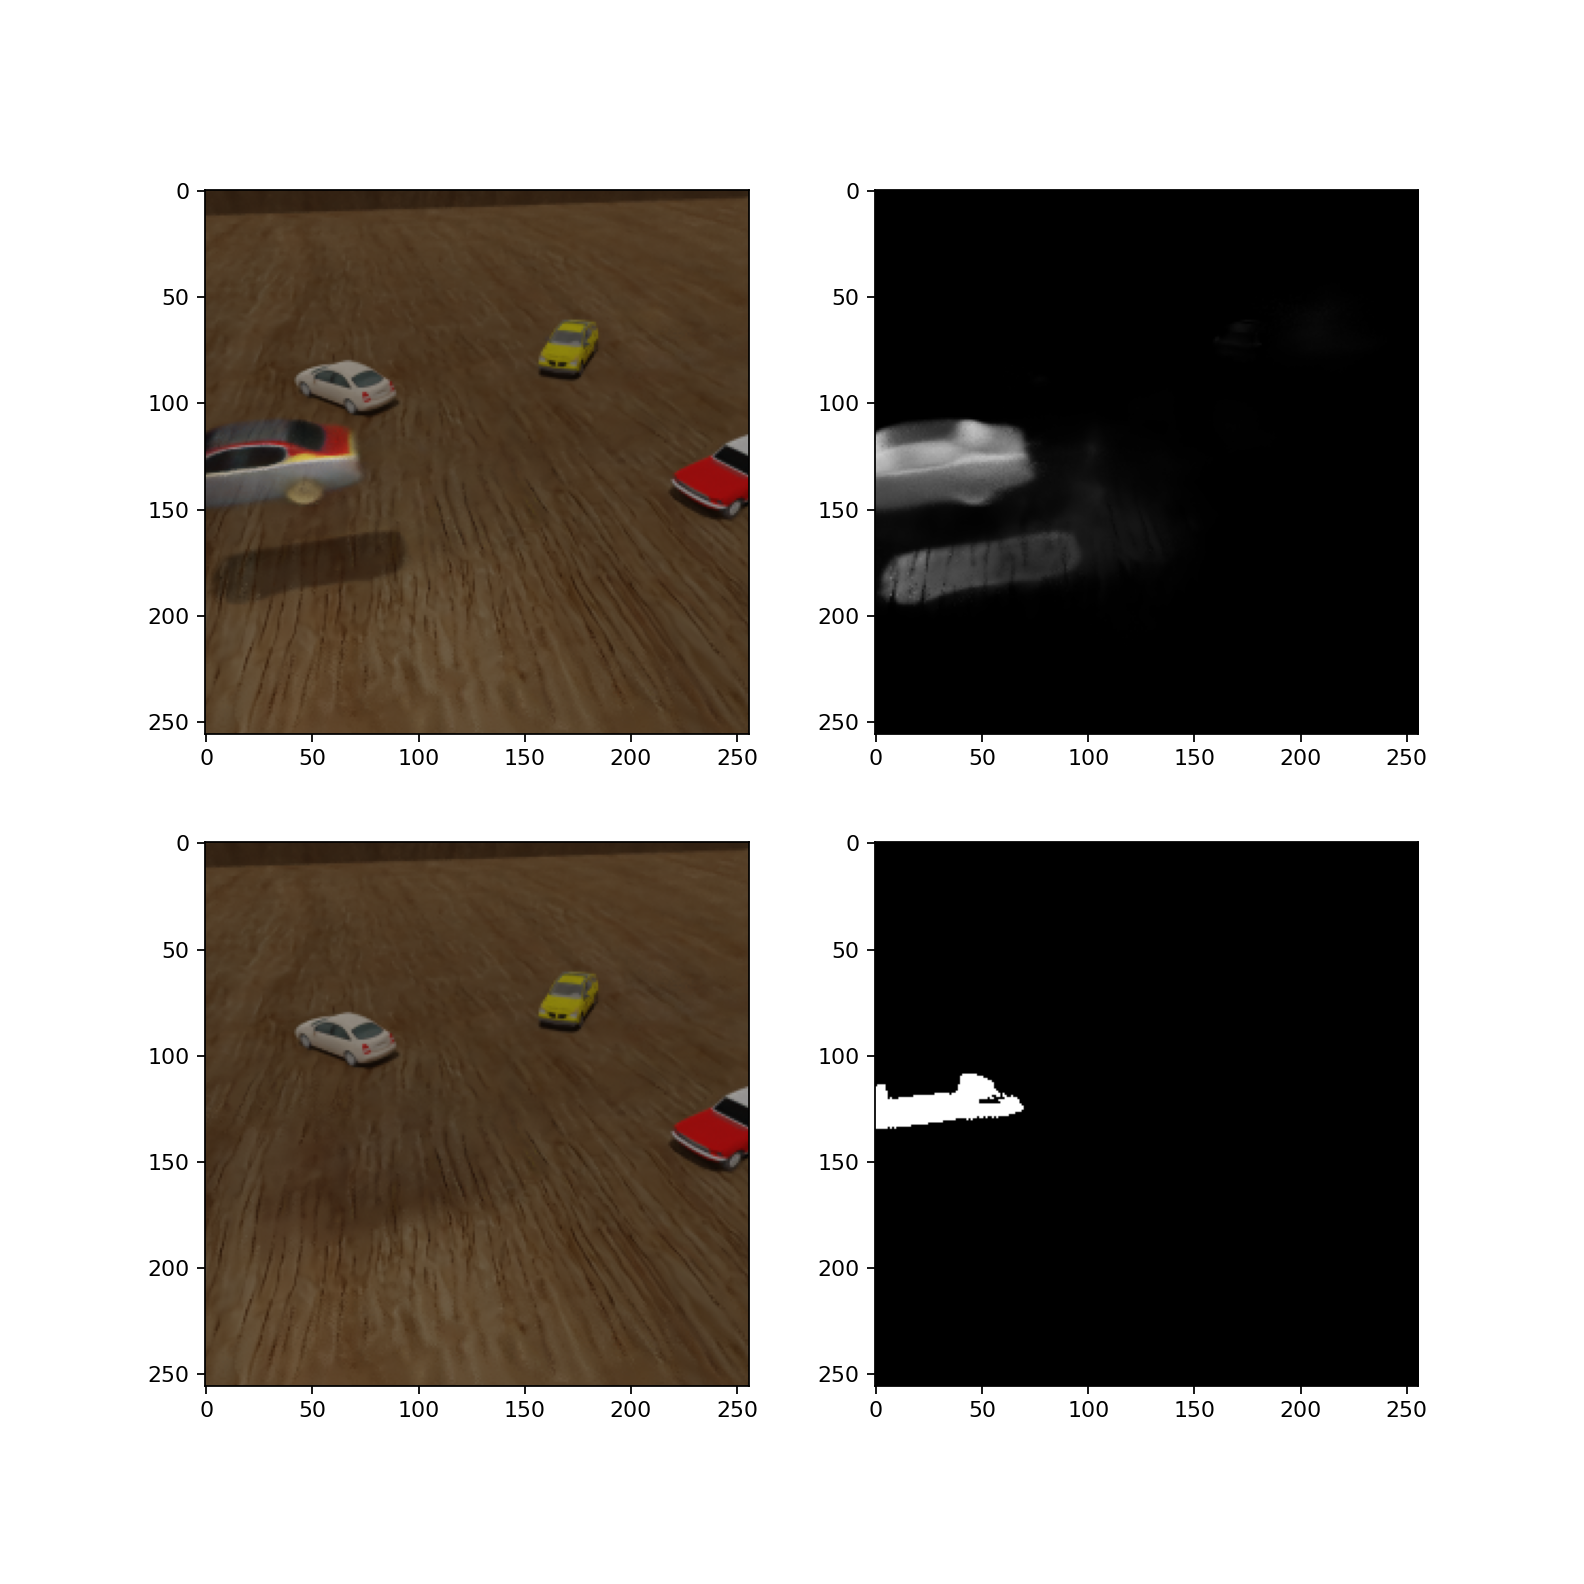

In [11]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10,10]
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].imshow(OUT['rgb'])
ax[0,1].imshow(OUT['extra_rgb_blendw'])
ax[1,0].imshow(OUT['extra_rgb_static'])
ax[1,1].imshow(OUT['extra_rgb_mask'])
plt.show()

In [12]:
# Note that pixel is obtained by rgb[y,x]
x, y = [22,111]
OUT['extra_rgb_blendw'][y,x]

array([0.19018887, 0.19018887, 0.19018887], dtype=float32)

In [14]:
OUT['blendw'][y,x]

array([0.36043802, 0.46795967, 0.4789708 , 0.4807975 , 0.4779036 ,
       0.47817925, 0.47836637, 0.4911619 , 0.49172056, 0.49278635,
       0.4931886 , 0.48701322, 0.48620734, 0.48797646, 0.48577315,
       0.48531443, 0.48676395, 0.4758295 , 0.46281415, 0.47036788,
       0.4658512 , 0.46585757, 0.43609673, 0.39195532, 0.23225097,
       0.12693454, 0.10741412, 0.00731794, 0.00519   , 0.00291618,
       0.00200051, 0.00082616, 0.00022962, 0.00008513, 0.00002408,
       0.00002332, 0.00000877, 0.00000838, 0.00000829, 0.00000298,
       0.00000778, 0.00003016, 0.00003332, 0.00002842, 0.0000269 ,
       0.00001359, 0.00000303, 0.00000257, 0.00000008, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [15]:
OUT['sigma_d'][y,x]

array([2.8849802 , 5.5335393 , 6.2921357 , 6.46455   , 6.6671414 ,
       6.692809  , 6.722798  , 7.33782   , 7.3849897 , 7.467643  ,
       7.498896  , 7.7864113 , 7.8260956 , 7.9183707 , 7.9320707 ,
       7.9354396 , 8.181505  , 8.30577   , 8.379347  , 9.193352  ,
       9.046764  , 9.046529  , 8.378486  , 7.154177  , 3.1210113 ,
       1.2720996 , 1.023982  , 0.0502619 , 0.03397413, 0.01806484,
       0.01230979, 0.00502226, 0.00120368, 0.00043705, 0.00011213,
       0.00010657, 0.00003129, 0.00002826, 0.00002758, 0.00000942,
       0.0000228 , 0.00009936, 0.00010716, 0.00009416, 0.00008789,
       0.00004146, 0.0000098 , 0.00000831, 0.00000026, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [16]:
OUT['sigma_s'][y,x]

array([ 5.1191154 ,  6.2912817 ,  6.8446474 ,  6.9809227 ,  7.283667  ,
        7.303635  ,  7.330862  ,  7.6018972 ,  7.6336827 ,  7.686272  ,
        7.70603   ,  8.201679  ,  8.270116  ,  8.30858   ,  8.396683  ,
        8.41569   ,  8.626449  ,  9.149578  ,  9.7258625 , 10.351672  ,
       10.373095  , 10.372559  , 10.833963  , 11.098356  , 10.317085  ,
        8.7495985 ,  8.509048  ,  6.8180485 ,  6.512103  ,  6.1766334 ,
        6.1410127 ,  6.0740232 ,  5.2408905 ,  5.133393  ,  4.655816  ,
        4.5702114 ,  3.5671003 ,  3.3741734 ,  3.3290343 ,  3.156554  ,
        2.929155  ,  3.2940109 ,  3.2162168 ,  3.313134  ,  3.2670448 ,
        3.0509253 ,  3.2378018 ,  3.2342958 ,  3.1684687 ,  3.0902796 ,
        5.943558  ,  8.472662  ,  9.542524  , 12.386315  , 12.279575  ,
       12.46262   , 11.837653  , 12.120486  , 11.493032  , 11.755511  ,
       11.312683  , 11.396535  ,  6.9424963 ,  5.3621674 ,  5.184707  ,
        4.089191  ,  1.5619857 ,  1.4606692 ,  2.171681  ,  2.61

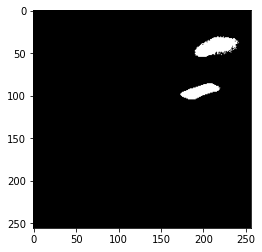

In [31]:
%matplotlib inline
plt.imshow(np.where(OUT['extra_rgb_blendw'] > 0.25, 1., 0.) )